<a href="https://colab.research.google.com/github/wagner1986/PapyrusTech/blob/main/LocalFeatureMatcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install kornia
!pip install kornia_moons

In [33]:
import torch
import torch.nn as nn
import torchvision
import kornia as K

class PreprocessPipeline(nn.Module):
    def __init__(self):
        super(PreprocessPipeline, self).__init__()
        self.transforms = nn.Sequential(
            # Normaliza a imagem para ter valores no intervalo [0, 1]
            K.enhance.Normalize(0.0, 255.0),
            # Redimensiona a imagem para o tamanho desejado
            K.geometry.Resize((200, 200)),
            # Converte a imagem RGB para escala de cinza
            K.color.RgbToGrayscale(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Normaliza a imagem para ter valores no intervalo [0, 1]
        x = x.float() / 255.0  # Garante que a operação de divisão é realizada em float
        # Aplica as transformações definidas em __init__
        x = self.transforms(x)
        # Adiciona uma dimensão de batch no início se ainda não houver
        if x.ndim == 3:
            x = x.unsqueeze(0)
        return x

# Inicializa o pipeline de preprocessamento
preprocess = PreprocessPipeline()


In [34]:
from kornia.feature import LocalFeatureMatcher,GFTTAffNetHardNet

# Carregar as duas imagens utilizando torchvision
img1 = torchvision.io.read_image("image1.jpg").float() / 255.0
img2 = torchvision.io.read_image("image2.jpg").float() / 255.0

# Aplica o pipeline de preprocessamento à imagem
img1_preprocessed = preprocess(img1)
# Aplica o pipeline de preprocessamento à imagem
img2_preprocessed = preprocess(img2)


input = {"image0": img1_preprocessed, "image1": img2_preprocessed}
gftt_hardnet_matcher = LocalFeatureMatcher(
    GFTTAffNetHardNet(25), K.feature.DescriptorMatcher('smnn', 0.85)
)
out = gftt_hardnet_matcher(input)
print(out['keypoints1'])

src_pts = out['lafs1'][0,:, :, 2].data.cpu().numpy()
src_pts

tensor([[118.0000,  81.0000],
        [ 12.7660, 112.7660],
        [117.7305,  80.8511],
        [ 31.0000, 154.0000],
        [ 16.0000, 180.0000],
        [ 20.0000, 157.0000],
        [ 15.0000, 146.0000]], grad_fn=<ViewBackward0>)


array([[118.      ,  81.      ],
       [ 12.765958, 112.76596 ],
       [117.7305  ,  80.85107 ],
       [ 31.      , 154.      ],
       [ 16.      , 180.      ],
       [ 20.      , 157.      ],
       [ 15.      , 146.      ]], dtype=float32)

torch.Size([7, 2]) <class 'torch.Tensor'> torch.Size([1, 7, 2, 3]) <class 'torch.Tensor'> torch.Size([7, 2])


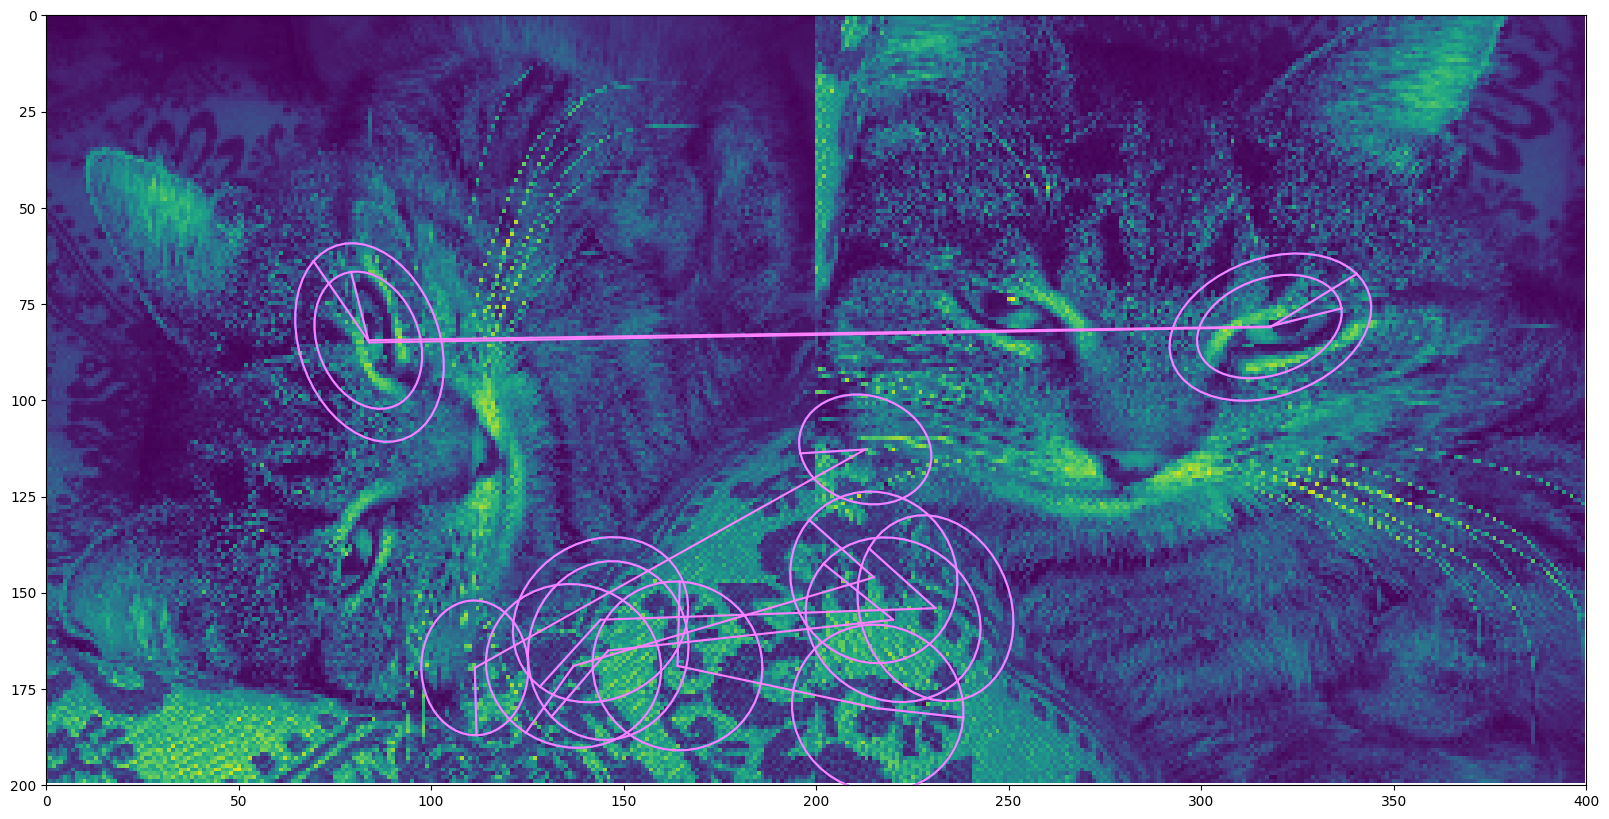

In [35]:
from kornia_moons.viz import draw_LAF_matches
n = out['keypoints1'].shape[0]
matching = torch.tensor([[i, i] for i in range(n)])
# Agora, desenhe os matchings
draw_LAF_matches(
    out['lafs0'],
    out['lafs1'],
    matching,
    K.tensor_to_image(img1_preprocessed.squeeze()),  # Garante que as imagens estão sem a dimensão de batch
    K.tensor_to_image(img2_preprocessed.squeeze()),
    None,  # Ou None se você não tiver uma máscara de inliers
    draw_dict={
        "inlier_color": (0.2, 1, 0.2),
        "tentative_color": (1.0, 0.5, 1),
        "feature_color": (0.2, 0.5, 1),
        "vertical": False,
    },
)
print(out['keypoints1'].shape,type(out['keypoints1']),
      out['lafs1'].shape,type(out['lafs1']),
      matching.shape,)

In [36]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
from scipy.spatial import Delaunay

INF = np.inf

# Calcula a distância Euclidiana entre dois pontos p1 e p2
def distancePoint(p1, p2):
    ax, ay = p1[0], p1[1]
    bx, by = p2[0], p2[1]
    dist = math.hypot(ax - bx, ay - by)
    return dist

# Aplica o algoritmo de Floyd-Warshall para encontrar as menores distâncias entre todos os pares de vértices
def floydWarshall(graph):
    graph = csr_matrix(graph)
    dist_matrix, predecessors = floyd_warshall(csgraph=graph, directed=False, return_predecessors=True)
    return dist_matrix

# Constrói a matriz de adjacência do grafo baseado em conexões entre pontos
def buildMapGraph(mapConex, mapPoint):
    size = len(mapPoint)
    sample = np.matrix(np.ones((size, size)) * np.inf)
    for i in range(size):
        sample[i, i] = 0  # Distância de um ponto para si mesmo é 0
    for conexao in mapConex:
        distance = distancePoint(mapPoint[conexao[0]], mapPoint[conexao[1]])
        sample[conexao[0], conexao[1]] = distance
    return sample

# Constrói conexões baseadas nos simplices da triangulação de Delaunay
def buildConnection(tri):
    mapConnection = []
    for simplice in tri.simplices:
        # Cada simplex representa um triângulo; adicione as arestas do triângulo ao grafo
        mapConnection.append([simplice[0], simplice[1]])
        mapConnection.append([simplice[1], simplice[2]])
        mapConnection.append([simplice[2], simplice[0]])
    return mapConnection

# Plota os pontos, a triangulação de Delaunay e os índices dos pontos
def plot_delaunay(points, tri,img):
    plt.imshow(img)
    plt.triplot(points[:, 0], points[:, 1], tri.simplices.copy(),color='orange')
    plt.plot(points[:, 0], points[:, 1], 'o')

    dist =3
    # Loop para adicionar os índices dos pontos
    for i, point in enumerate(points):
        plt.text(point[0]+dist, point[1]+dist, f' {i}', color='red', fontsize=12)

    plt.show()

# Extrai o grafo a partir de um conjunto de pontos usando Delaunay, e calcula a matriz de distâncias usando Floyd-Warshall
def extract_graph(points):
    tri = Delaunay(points)
    print("pts ",points)
    mapConnection = buildConnection(tri)
    sample = buildMapGraph(mapConnection, points)
    graphCalc = floydWarshall(sample)
    print("mc ",graphCalc)
    return graphCalc, points, tri

# Compara duas matrizes de distância e conta os elementos cuja diferença é menor que um limiar
def match_matrix(mat_a, mat_b):
    mat_dist = mat_b - mat_a
    for i in range(mat_dist.shape[0]):
        mat_dist[i, :i] = 0  # Zera a metade inferior da matriz para evitar duplicação
    mat_dist = mat_dist * mat_dist  # Eleva as diferenças ao quadrado
    points = 0
    for i in range(mat_dist.shape[0]):
        for j in range(i + 1, mat_dist.shape[0]):
            if mat_dist[i, j] < 9:  # Limiar de similaridade
                points += 1
    return points

pts  [[ 84.       85.     ]
 [111.34752 169.50356]
 [ 83.68794  84.39716]
 [144.      157.     ]
 [164.      169.     ]
 [146.      165.     ]
 [137.      169.     ]]
mc  [[  0.          88.8185659    0.67881651  93.72299611 116.
  101.96920736 107.6154401 ]
 [ 88.8185659    0.          89.48826801  34.96460232  52.65488896
   35.50628077  25.65742297]
 [  0.67881651  89.48826801   0.          94.40181262 116.65190329
  102.64802387 108.29425661]
 [ 93.72299611  34.96460232  94.40181262   0.          23.32380758
    8.24621125  13.89244399]
 [116.          52.65488896 116.65190329  23.32380758   0.
   18.43908891  27.        ]
 [101.96920736  35.50628077 102.64802387   8.24621125  18.43908891
    0.           9.8488578 ]
 [107.6154401   25.65742297 108.29425661  13.89244399  27.
    9.8488578    0.        ]]


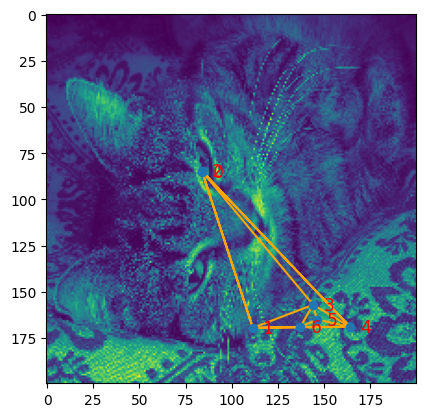

pts  [[118.        81.      ]
 [ 12.765958 112.76596 ]
 [117.7305    80.85107 ]
 [ 31.       154.      ]
 [ 16.       180.      ]
 [ 20.       157.      ]
 [ 15.       146.      ]]
mc  [[  0.         110.01714378   0.30791526 113.56936207 142.14429289
  124.97111632 131.45790589]
 [110.01714378   0.         109.70922853  45.08576634  67.31177512
   45.39208849  33.30904251]
 [  0.30791526 109.70922853   0.         113.45900565 142.45220814
  124.8607599  131.34754947]
 [113.56936207  45.08576634 113.45900565   0.          30.01666204
   11.40175425  17.88854382]
 [142.14429289  67.31177512 142.45220814  30.01666204   0.
   23.34523506  34.0147027 ]
 [124.97111632  45.39208849 124.8607599   11.40175425  23.34523506
    0.          12.08304597]
 [131.45790589  33.30904251 131.34754947  17.88854382  34.0147027
   12.08304597   0.        ]]


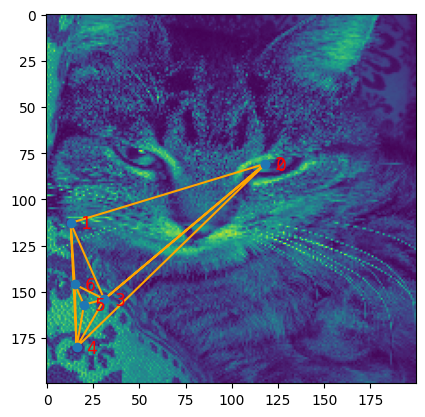

Matching Points: 2


In [37]:
pts0=out['keypoints0'].detach().numpy()
# Extrai o grafo, calcula as distâncias mínimas e obtém a triangulação de Delaunay
dist_matrix0, new_points0, tri0 = extract_graph(pts0)
# Plota a triangulação de Delaunay
plot_delaunay(new_points0, tri0,K.tensor_to_image(img1_preprocessed.squeeze()))

pts1=out['keypoints1'].detach().numpy()
# Extrai o grafo, calcula as distâncias mínimas e obtém a triangulação de Delaunay
dist_matrix1, new_points1, tri1 = extract_graph(pts1)
# Plota a triangulação de Delaunay
plot_delaunay(new_points1, tri1,K.tensor_to_image(img2_preprocessed.squeeze()))

# Compara as matrizes de distância dos dois grafos
matching_points = match_matrix(dist_matrix0, dist_matrix1)
print(f"Matching Points: {matching_points}")


In [38]:
class CustomLocalFeatureMatcher:
    def __init__(self, feature_extractor, descriptor_matcher):
        self.feature_extractor = feature_extractor
        self.descriptor_matcher = descriptor_matcher

    def __call__(self, input):
        image0, image1 = input["image0"], input["image1"]

        # Extrair pontos-chave e descritores
        lafs0,x0, descriptors0 = self.feature_extractor(image0)
        lafs1,x1, descriptors1 = self.feature_extractor(image1)

        distance,matches = self.descriptor_matcher(descriptors0[0],descriptors1[0])
        keypoints0 = lafs0[0,:, :, 2].data
        keypoints1 = lafs1[0,:, :, 2].data

        # Retorna os keypoints, descritores e correspondências
        return {
            "keypoints0": keypoints0,
            "keypoints1": keypoints1,
            "lafs0": lafs0,
            "lafs1": lafs1,
            "descriptors0": descriptors0[0],
            "descriptors1": descriptors1[0],
            "matches": matches
        }

customFeatureMatcher = CustomLocalFeatureMatcher(
    GFTTAffNetHardNet(25), K.feature.DescriptorMatcher('smnn', 0.85)
)

out2 = customFeatureMatcher(input)

print(out2['keypoints1'].shape,type(out2['keypoints1']),
      out2['lafs1'].shape,type(out2['lafs1']),
      out2['matches'].shape,)

torch.Size([25, 2]) <class 'torch.Tensor'> torch.Size([1, 25, 2, 3]) <class 'torch.Tensor'> torch.Size([7, 2])


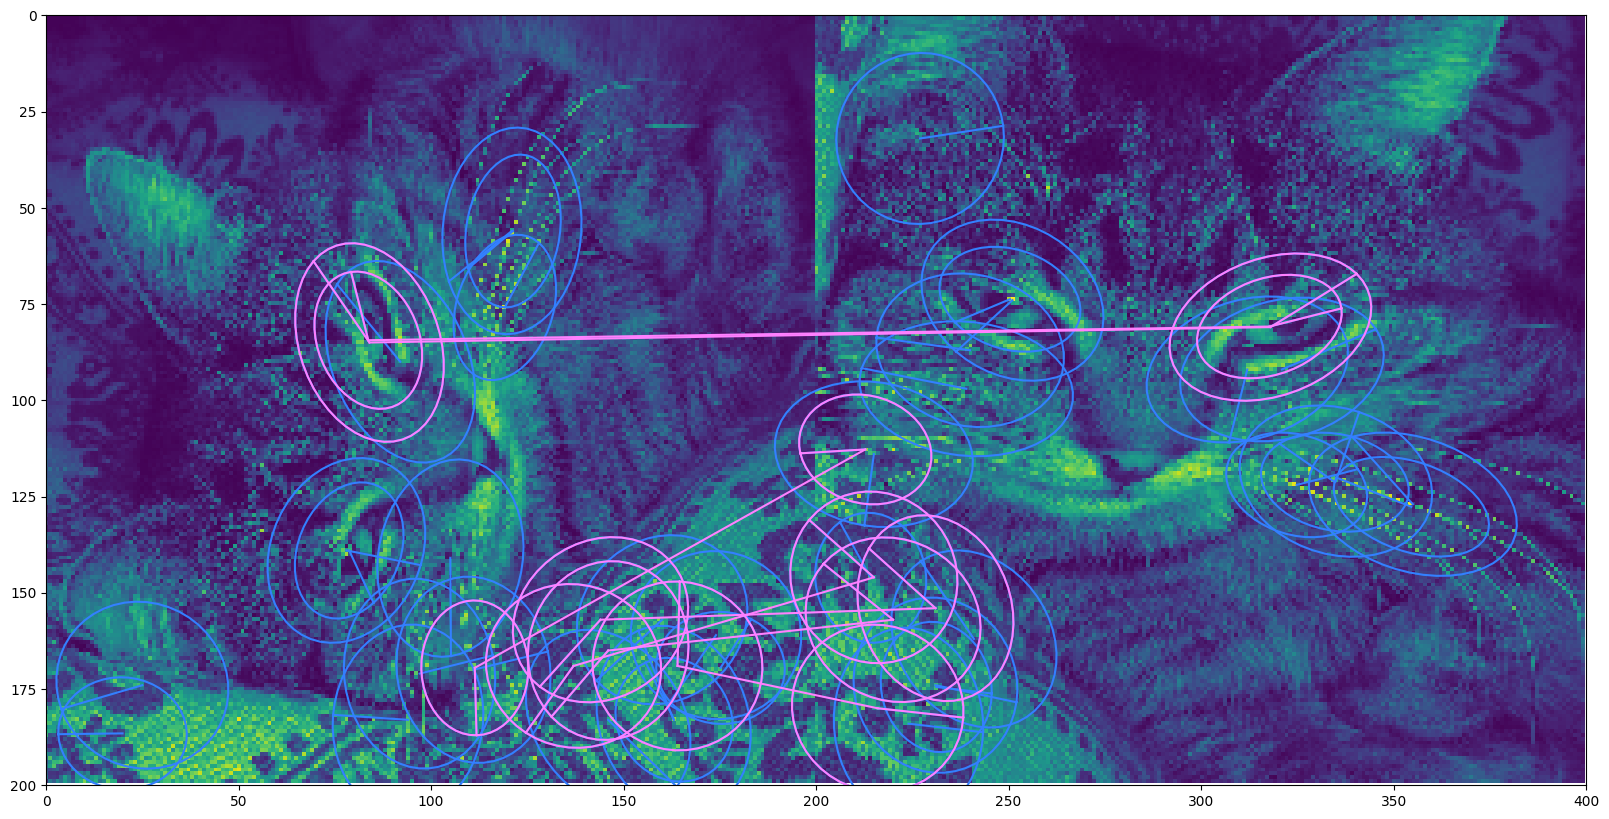

In [39]:
from kornia_moons.viz import draw_LAF_matches
# Agora, desenhe os matchings
draw_LAF_matches(
    out2['lafs0'],
    out2['lafs1'],
    out2['matches'],
    K.tensor_to_image(img1_preprocessed.squeeze()),  # Garante que as imagens estão sem a dimensão de batch
    K.tensor_to_image(img2_preprocessed.squeeze()),
    None,  # Ou None se você não tiver uma máscara de inliers
    draw_dict={
        "inlier_color": (0.2, 1, 0.2),
        "tentative_color": (1.0, 0.5, 1),
        "feature_color": (0.2, 0.5, 1),
        "vertical": False,
    },
)

pts  [[ 84.       85.     ]
 [111.34752 169.50356]
 [ 83.68794  84.39716]
 [144.      157.     ]
 [164.      169.     ]
 [146.      165.     ]
 [137.      169.     ]]
mc  [[  0.          88.8185659    0.67881651  93.72299611 116.
  101.96920736 107.6154401 ]
 [ 88.8185659    0.          89.48826801  34.96460232  52.65488896
   35.50628077  25.65742297]
 [  0.67881651  89.48826801   0.          94.40181262 116.65190329
  102.64802387 108.29425661]
 [ 93.72299611  34.96460232  94.40181262   0.          23.32380758
    8.24621125  13.89244399]
 [116.          52.65488896 116.65190329  23.32380758   0.
   18.43908891  27.        ]
 [101.96920736  35.50628077 102.64802387   8.24621125  18.43908891
    0.           9.8488578 ]
 [107.6154401   25.65742297 108.29425661  13.89244399  27.
    9.8488578    0.        ]]


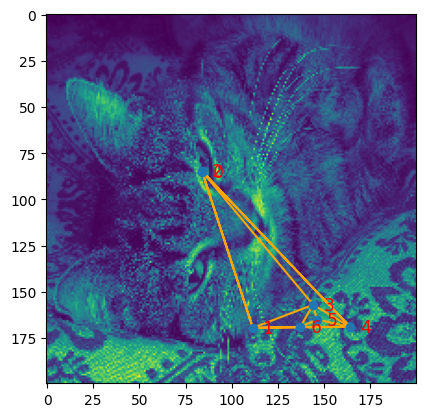

pts  [[118.        81.      ]
 [ 12.765958 112.76596 ]
 [117.7305    80.85107 ]
 [ 31.       154.      ]
 [ 16.       180.      ]
 [ 20.       157.      ]
 [ 15.       146.      ]]
mc  [[  0.         110.01714378   0.30791526 113.56936207 142.14429289
  124.97111632 131.45790589]
 [110.01714378   0.         109.70922853  45.08576634  67.31177512
   45.39208849  33.30904251]
 [  0.30791526 109.70922853   0.         113.45900565 142.45220814
  124.8607599  131.34754947]
 [113.56936207  45.08576634 113.45900565   0.          30.01666204
   11.40175425  17.88854382]
 [142.14429289  67.31177512 142.45220814  30.01666204   0.
   23.34523506  34.0147027 ]
 [124.97111632  45.39208849 124.8607599   11.40175425  23.34523506
    0.          12.08304597]
 [131.45790589  33.30904251 131.34754947  17.88854382  34.0147027
   12.08304597   0.        ]]


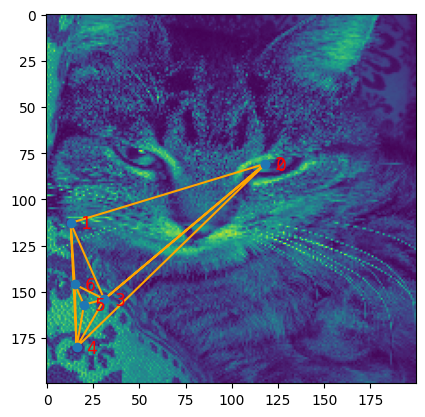

Matching Points: 2


In [40]:
pts0=out2['keypoints0'][out2['matches'][:, 0]].detach().numpy()
# Extrai o grafo, calcula as distâncias mínimas e obtém a triangulação de Delaunay
dist_matrix0, new_points0, tri0 = extract_graph(pts0)
# Plota a triangulação de Delaunay
plot_delaunay(new_points0, tri0,K.tensor_to_image(img1_preprocessed.squeeze()))

pts1= out2['keypoints1'][out2['matches'][:, 1]].detach().numpy()
# Extrai o grafo, calcula as distâncias mínimas e obtém a triangulação de Delaunay
dist_matrix1, new_points1, tri1 = extract_graph(pts1)
# Plota a triangulação de Delaunay
plot_delaunay(new_points1, tri1,K.tensor_to_image(img2_preprocessed.squeeze()))

# Compara as matrizes de distância dos dois grafos
matching_points = match_matrix(dist_matrix0, dist_matrix1)
print(f"Matching Points: {matching_points}")
